In [2]:
import os
import warnings

import torchaudio
from torch.utils.data import Dataset
from torchaudio.datasets.utils import download_url, extract_archive, walk_files

from ast import literal_eval
from pathlib import Path

import pandas as pd

import torchaudio
import torch
import fastai
import fastai.vision
from fastai.basics import *
from torchvision import transforms
import matplotlib.pyplot as plt

In [114]:


data_path = Path('D:/MachineLearning/deepSync/data/')

class AirbudDataset(Dataset):
    """
    Create a Dataset for Audio. Each item is a tuple of the form:
    (waveform, sample_rate, labels)
    """

    def __init__(
        self,
        root,
        data_path='data',
        anim_csv='data2.csv',
        audio_ext='.aif',
        download=False,
        transform=None,
        target_transform=None,
    ):

        self.transform = transform
        self.target_transform = target_transform

        # archive = os.path.basename(url)
        # archive = os.path.join(root, archive)
        # self._path = os.path.join(root, folder_in_archive)

        # if download:
        #     if not os.path.isdir(self._path):
        #         if not os.path.isfile(archive):
        #             download_url(url, root)
        #         extract_archive(archive)

        self._audio_path = root/data_path/Path('Audio')
        self._anim_path = root/data_path/Path(anim_csv)
        self._ext_audio = audio_ext

        if not os.path.isdir(self._audio_path):
            raise RuntimeError(
                "Dataset not found. Please use `download=True` to download it."
            )

        walker = walk_files(
            self._audio_path, suffix=self._ext_audio, prefix=False, remove_suffix=True
        )

        self._walker = list(walker)
        self.df = self._process_df(pd.read_csv(self._anim_path))
        

    def _process_df(self, df):
        def convert_to_list(x):
          try:
              y = literal_eval(x)
              return y
          except:
              return x
        
        def convert_floats(x):
            if isinstance(x, float):
                return [x]
            else:
                return x

        df['jawTrans_ty'] = df['jawTrans_ty'].fillna('0.0')
        df['jawTrans_ty'] = df['jawTrans_ty'].apply(lambda x: convert_to_list(x))
        df['jawTrans_ty'] = df['jawTrans_ty'].apply(lambda x: convert_floats(x))
        return df

    def _get_labels(self, fileid):
        y_vals = self.df[self.df['Audio File'].str.contains(fileid)]['jawTrans_ty'].values[0]
        return y_vals


    def _load_audio_item(self, fileid):
        # Read label
        labels = self._get_labels(fileid)

        # Read audio
        filepath = str(self._audio_path / Path(fileid)) + self._ext_audio

        waveform, sample_rate = torchaudio.load(filepath)

        return waveform, sample_rate, labels



    def __getitem__(self, n):
        fileid = self._walker[n]
        item = self._load_audio_item(fileid)

        waveform, sample_rate, labels = item
        
        labels = torch.Tensor(labels).unsqueeze(dim=0)
        
        if self.transform is not None:
            waveform = self.transform(waveform)
        if self.target_transform is not None:
            labels = self.target_transform(labels)

        return waveform, sample_rate, labels

    def __len__(self):
        return len(self._walker)

In [124]:
class PadTrim(object):
    """Pad/Trim a 1d-Tensor (Signal or Labels)
    Args:
        tensor (Tensor): Tensor of audio of size (n x c) or (c x n)
        max_len (int): Length to which the tensor will be padded
        channels_first (bool): Pad for channels first tensors.  Default: `True`
    """

    def __init__(self, max_len, fill_value=0, channels_first=True):
        self.max_len = max_len
        self.fill_value = fill_value
        self.len_dim, self.ch_dim = int(channels_first), int(not channels_first)

    def __call__(self, tensor):
        """
        Returns:
            Tensor: (c x n) or (n x c)
        """
        assert tensor.size(self.ch_dim) < 128, \
            "Too many channels ({}) detected, see channels_first param.".format(tensor.size(self.ch_dim))
        if self.max_len > tensor.size(self.len_dim):
            padding = [self.max_len - tensor.size(self.len_dim)
                       if (i % 2 == 1) and (i // 2 != self.len_dim)
                       else 0
                       for i in range(4)]
            with torch.no_grad():
                tensor = torch.nn.functional.pad(tensor, padding, "constant", self.fill_value)
        elif self.max_len < tensor.size(self.len_dim):
            tensor = tensor.narrow(self.len_dim, 0, self.max_len)
        return tensor

    def __repr__(self):
        return self.__class__.__name__ + '(max_len={0})'.format(self.max_len)

In [133]:
from torchvision import transforms
import torch 
transform = transforms.Compose([
#                                 torchaudio.transforms.AmplitudeToDB(stype='power', top_db=None),
#                                 PadTrim(500),
                                torchaudio.transforms.Spectrogram(n_fft=400, win_length=None, hop_length=None, pad=0, power=2, normalized=False),
                                transforms.ToPILImage(),
#                                 transforms.Resize((240,240)),
                                transforms.ToTensor()]
                               )

target_transform = transforms.Compose([
                                PadTrim(240)
                                ]
                               )

In [134]:
root = Path('D:\MachineLearning\deepSync')
dataset = AirbudDataset(root, transform=transform, target_transform=target_transform)

In [135]:
dataset[0][0].shape

torch.Size([1, 201, 831])

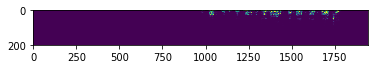

In [136]:
plt.imshow(dataset[2][0].squeeze())

In [139]:
from IPython.display import Audio
def show_audio(ad):
    sig,sr=ad
    display(Audio(data=sig, rate=sr))

In [140]:
show_audio((dataset[0][0], dataset[0][1]))

ValueError: Array audio input must be a 1D or 2D array